In [ ]:
import copy
import json
import os
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

from analysis.modeling.utils import calculate_metrics, load_and_split_data, plot_predictions_vs_actuals_v2, plot_residuals

# DATA LOAD


In [5]:
df_train, df_validation, df_test = load_and_split_data()

TARGET = "eq_operational_carbon_emission_t"
FEATURES_FUTURE = [
    "t_hours_since_start",
    "t_days_since_start",
    "t_weeks_since_start",
    "t_hour_sin",
    "t_hour_cos",
    "t_day_sin",
    "t_day_cos",
    "t_month_sin",
    "t_month_cos",
    "t_quarter_sin",
    "t_quarter_cos",
    "t_year",
    "t_year_month",
    "eq_consumption",
    "eq_solar_photovoltaic_production",
    "eq_wind_power_production_offshore",
    "eq_wind_power_production_onshore",
    "eq_residual_power_production_day_ahead",
    "eq_price_spot_day_ahead_eur",
    "eq_dk1_exchange_day_ahead_schedule_net_export",
    "eq_temperature",
]
FEATURES_HIST = [*FEATURES_FUTURE, TARGET]

-------- Data Splits --------
Original:   26,304 rows
Train:      18,412 rows (70%)
Validation:  3,946 rows (15%)
Test:        3,946 rows (15%)


# NAIVE PERSISTENCE - PREP


In [3]:
def naive(df: pl.DataFrame, horizon: int) -> tuple[np.ndarray, np.ndarray]:
    y_values = df["eq_operational_carbon_emission_t"].to_numpy()

    predictions = []
    actuals = []

    for i in range(df.shape[0] - horizon):
        preds = np.full(horizon, y_values[i])
        acts = y_values[i + 1 : i + 1 + horizon]

        predictions.append(preds)
        actuals.append(acts)

    return np.array(predictions), np.array(actuals)

# NAIVE PERSISTENCE - POINT


In [4]:
print("-------- Train metrics for naive point model --------")
naive_point_train_predictions, naive_point_train_actuals = naive(df_train, horizon=1)
naive_point_train_metrics = calculate_metrics(naive_point_train_predictions, naive_point_train_actuals)

print("\n-------- Validation metrics for naive point model --------")
naive_point_validation_predictions, naive_point_validation_actuals = naive(df_validation, horizon=1)
naive_point_validation_metrics = calculate_metrics(naive_point_validation_predictions, naive_point_validation_actuals)

print("\n-------- Test metrics for naive point model --------")
naive_point_test_predictions, naive_point_test_actuals = naive(df_test, horizon=1)
lstm_point_test_metrics = calculate_metrics(naive_point_test_predictions, naive_point_test_actuals)
# plot_residuals(naive_test_predictions, naive_test_actuals, title="Residuals for naive model")

-------- Train metrics for naive point model --------
MAE: 8.2459
MSE: 172.9188
RMSE: 13.1499
MAPE: 9.7295
R2: 0.9554

-------- Validation metrics for naive point model --------
MAE: 6.6261
MSE: 117.3615
RMSE: 10.8334
MAPE: 11.5210
R2: 0.9328

-------- Test metrics for naive point model --------
MAE: 6.1271
MSE: 111.1065
RMSE: 10.5407
MAPE: 10.8407
R2: 0.9066


# NAIVE PERSISTENCE - SEQUENCE


In [5]:
print("-------- Train metrics for naive sequence model --------")
naive_seq_train_predictions, naive_seq_train_actuals = naive(df_train, horizon=24)
naive_train_metrics = calculate_metrics(naive_seq_train_predictions, naive_seq_train_actuals)

print("\n-------- Validation metrics for naive sequence model --------")
naive_seq_validation_predictions, naive_seq_validation_actuals = naive(df_validation, horizon=24)
naive_seq_validation_metrics = calculate_metrics(naive_seq_validation_predictions, naive_seq_validation_actuals)

print("\n-------- Test metrics for naive sequence model --------")
naive_seq_test_predictions, naive_seq_test_actuals = naive(df_test, horizon=24)
lstm_point_test_metrics = calculate_metrics(naive_seq_test_predictions, naive_seq_test_actuals)
# plot_residuals(naive_test_predictions, naive_test_actuals, title="Residuals for naive model")

-------- Train metrics for naive sequence model --------
MAE: 24.8934
MSE: 1476.9941
RMSE: 38.4317
MAPE: 31.3286
R2: 0.6192

-------- Validation metrics for naive sequence model --------
MAE: 18.1905
MSE: 721.5724
RMSE: 26.8621
MAPE: 36.4706
R2: 0.5809

-------- Test metrics for naive sequence model --------
MAE: 20.3272
MSE: 884.7998
RMSE: 29.7456
MAPE: 41.0018
R2: 0.2562


# ARIMA - PREP


In [6]:
class ARIMAPreppedData(NamedTuple):
    y: np.ndarray


def arima_prep_data(df: pl.DataFrame) -> ARIMAPreppedData:
    y = df[TARGET].to_numpy()
    return ARIMAPreppedData(y)


arima_train_prepped = arima_prep_data(
    df=df_train,
)

arima_validation_prepped = arima_prep_data(
    df=df_validation,
)

arima_test_prepped = arima_prep_data(
    df=df_test,
)


def arima_predict(arima_model: ARIMA, prepped_data: ARIMAPreppedData, horizon: int) -> tuple[np.ndarray, np.ndarray]:
    predictions = []
    actuals = []

    arima_model_copy = copy.deepcopy(arima_model)

    for i in range(prepped_data.y.shape[0] - horizon):
        preds = arima_model_copy.forecast(steps=horizon)[0:horizon]
        predictions.append(preds)

        acts = prepped_data.y[i + 1 : i + 1 + horizon]
        actuals.append(acts)

        arima_model_copy = arima_model_copy.extend([acts[0]])

    return np.array(predictions), np.array(actuals)

# ARIMA - POINT & SEQ


In [7]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1]
q_values = [0, 1, 2, 3, 4, 5]
trend_options = ["n", "c", "t"]  # None, Constant, Linear Trend

arima_checkpoint_path = "arima.json"

if os.path.exists(arima_checkpoint_path):
    with open(arima_checkpoint_path, "r") as file:
        arima_models = json.load(file)
        existing_params = {
            (
                arima_model["p"],
                arima_model["d"],
                arima_model["q"],
                arima_model["t"],
            )
            for arima_model in arima_models
        }
else:
    with open(arima_checkpoint_path, "w") as file:
        arima_models = []
        existing_params = set()
        json.dump(arima_models, file, indent=4)

arima_param_combinations = list(
    product(
        p_values,
        d_values,
        q_values,
        trend_options,
    )
)

for arima_combo in arima_param_combinations:
    if arima_combo in existing_params:
        print(f"Combo {arima_combo} already estimated!")
        continue
    else:
        print(f"Combo {arima_combo} is being estimated...")

    p, d, q, t = arima_combo

    try:
        arima_model = ARIMA(arima_train_prepped.y, order=(p, d, q), trend=t).fit()

        # Point metrics
        train_point_predictions, train_point_actuals = arima_predict(arima_model, arima_train_prepped, horizon=1)
        train_point_metrics = calculate_metrics(train_point_predictions, train_point_actuals, verbose=False)

        validation_point_predictions, validation_point_actuals = arima_predict(arima_model, arima_validation_prepped, horizon=1)
        validation_point_metrics = calculate_metrics(validation_point_predictions, validation_point_actuals, verbose=False)

        test_point_predictions, test_point_actuals = arima_predict(arima_model, arima_test_prepped, horizon=1)
        test_point_metrics = calculate_metrics(test_point_predictions, test_point_actuals, verbose=False)

        # Sequence metrics
        train_seq_predictions, train_seq_actuals = arima_predict(arima_model, arima_train_prepped, horizon=24)
        train_seq_metrics = calculate_metrics(train_seq_predictions, train_seq_actuals, verbose=False)

        validation_seq_predictions, validation_seq_actuals = arima_predict(arima_model, arima_validation_prepped, horizon=24)
        validation_seq_metrics = calculate_metrics(validation_seq_predictions, validation_seq_actuals, verbose=False)

        test_seq_predictions, test_seq_actuals = arima_predict(arima_model, arima_test_prepped, horizon=24)
        test_seq_metrics = calculate_metrics(test_seq_predictions, test_seq_actuals, verbose=False)

        arima_models.append(
            {
                "message": "success",
                "p": p,
                "d": d,
                "q": q,
                "t": t,
                "aic": arima_model.aic,
                "bic": arima_model.bic,
                "train_point_metrics": train_point_metrics,
                "validation_point_metrics": validation_point_metrics,
                "test_point_metrics": test_point_metrics,
                "train_sequence_metrics": train_seq_metrics,
                "validation_sequence_metrics": validation_seq_metrics,
                "test_sequence_metrics": test_seq_metrics,
            }
        )
        arima_model.save(f"arimas/p_{p}_d_{d}_q_{q}_t_{t}.pkl")
    except Exception as e:  # noqa: BLE001
        arima_models.append(
            {
                "message": f"Combo failed with error: {e}",
                "p": p,
                "d": d,
                "q": q,
                "t": t,
            }
        )

    with open(arima_checkpoint_path, "w") as file:
        json.dump(arima_models, file, indent=4)

Combo (0, 0, 0, 'n') already estimated!
Combo (0, 0, 0, 'c') already estimated!
Combo (0, 0, 0, 't') already estimated!
Combo (0, 0, 1, 'n') already estimated!
Combo (0, 0, 1, 'c') already estimated!
Combo (0, 0, 1, 't') already estimated!
Combo (0, 0, 2, 'n') already estimated!
Combo (0, 0, 2, 'c') already estimated!
Combo (0, 0, 2, 't') already estimated!
Combo (0, 0, 3, 'n') already estimated!
Combo (0, 0, 3, 'c') already estimated!
Combo (0, 0, 3, 't') already estimated!
Combo (0, 0, 4, 'n') already estimated!
Combo (0, 0, 4, 'c') already estimated!
Combo (0, 0, 4, 't') already estimated!
Combo (0, 0, 5, 'n') already estimated!
Combo (0, 0, 5, 'c') already estimated!
Combo (0, 0, 5, 't') already estimated!
Combo (0, 1, 0, 'n') already estimated!
Combo (0, 1, 0, 'c') already estimated!
Combo (0, 1, 0, 't') already estimated!
Combo (0, 1, 1, 'n') already estimated!
Combo (0, 1, 1, 'c') already estimated!
Combo (0, 1, 1, 't') already estimated!
Combo (0, 1, 2, 'n') already estimated!


In [8]:
with open(arima_checkpoint_path, "r") as file:
    arima_models: list[dict] = json.load(file)

arima_best_validation_point_rmse = float("inf")
arima_best_validation_seq_rmse = float("inf")

for arima_model in arima_models:
    validation_point_rmse = arima_model.get("validation_point_metrics", {}).get("RMSE", float("inf"))
    validation_seq_rmse = arima_model.get("validation_sequence_metrics", {}).get("RMSE", float("inf"))

    if validation_point_rmse < arima_best_validation_point_rmse:
        arima_best_validation_point_rmse = validation_point_rmse
        arima_best_point_model = arima_model

    if validation_seq_rmse < arima_best_validation_seq_rmse:
        arima_best_validation_seq_rmse = validation_seq_rmse
        arima_best_seq_model = arima_model

print(f"Best ARIMA validation point RMSE: {arima_best_validation_point_rmse:.4f}")
print(f"Best ARIMA validation sequence RMSE: {arima_best_validation_seq_rmse:.4f}")

print("\n-------- Best ARIMA point model --------")
print(f"    p: {arima_best_point_model['p']}")
print(f"    d: {arima_best_point_model['d']}")
print(f"    q: {arima_best_point_model['q']}")
print(f"    t: {arima_best_point_model['t']}")
print(f"    AIC: {arima_best_point_model['aic']:.4f}")
print(f"    BIC: {arima_best_point_model['bic']:.4f}")
print("    Train metrics:")
for metric, value in arima_best_point_model["train_point_metrics"].items():
    print(f"        {metric}: {value:.4f}")
print("    Validation metrics:")
for metric, value in arima_best_point_model["validation_point_metrics"].items():
    print(f"        {metric}: {value:.4f}")
print("    Test metrics:")
for metric, value in arima_best_point_model["test_point_metrics"].items():
    print(f"        {metric}: {value:.4f}")

print("\n-------- Best ARIMA sequence model --------")
print(f"    p: {arima_best_seq_model['p']}")
print(f"    d: {arima_best_seq_model['d']}")
print(f"    q: {arima_best_seq_model['q']}")
print(f"    t: {arima_best_seq_model['t']}")
print(f"    AIC: {arima_best_seq_model['aic']:.4f}")
print(f"    BIC: {arima_best_seq_model['bic']:.4f}")
print("    Train metrics:")
for metric, value in arima_best_seq_model["train_sequence_metrics"].items():
    print(f"        {metric}: {value:.4f}")
print("    Validation metrics:")
for metric, value in arima_best_seq_model["validation_sequence_metrics"].items():
    print(f"        {metric}: {value:.4f}")
print("    Test metrics:")
for metric, value in arima_best_seq_model["test_sequence_metrics"].items():
    print(f"        {metric}: {value:.4f}")


Best ARIMA validation point RMSE: 9.5230
Best ARIMA validation sequence RMSE: 21.5802

-------- Best ARIMA point model --------
    p: 5
    d: 0
    q: 5
    t: n
    AIC: 144053.4043
    BIC: 144139.4326
    Train metrics:
        MAE: 7.9004
        MSE: 146.2336
        RMSE: 12.0927
        MAPE: 9.8724
        R2: 0.9623
    Validation metrics:
        MAE: 6.3496
        MSE: 90.6872
        RMSE: 9.5230
        MAPE: 12.6528
        R2: 0.9481
    Test metrics:
        MAE: 5.9913
        MSE: 88.9766
        RMSE: 9.4327
        MAPE: 11.9008
        R2: 0.9252

-------- Best ARIMA sequence model --------
    p: 5
    d: 0
    q: 5
    t: n
    AIC: 144053.4043
    BIC: 144139.4326
    Train metrics:
        MAE: 22.0357
        MSE: 1101.1898
        RMSE: 33.1842
        MAPE: 29.1762
        R2: 0.7161
    Validation metrics:
        MAE: 15.4622
        MSE: 465.7057
        RMSE: 21.5802
        MAPE: 34.8770
        R2: 0.7295
    Test metrics:
        MAE: 18.2073
     

# LSTM - PREP


In [6]:
class LSTMPreppedDataWithForecasts(NamedTuple):
    x_tensor_hist: tf.Tensor
    x_tensor_future: tf.Tensor
    y_tensor: tf.Tensor
    x_scaler_hist: MinMaxScaler
    x_scaler_future: MinMaxScaler
    y_scaler: MinMaxScaler


def lstm_transform_and_prep_data_with_forecasts(
    df: pl.DataFrame,
    input_seq_len: int,
    output_seq_len: int,
    x_scaler_hist: MinMaxScaler = None,
    x_scaler_future: MinMaxScaler = None,
    y_scaler: MinMaxScaler = None,
) -> LSTMPreppedDataWithForecasts:
    x_hist = df.select(FEATURES_HIST).to_numpy()
    x_future = df.select(FEATURES_FUTURE).to_numpy()

    y = df.select(TARGET).to_numpy()

    if not x_scaler_hist:
        x_scaler_hist = MinMaxScaler()
        x_scaled_hist = x_scaler_hist.fit_transform(x_hist)
    else:
        x_scaled_hist = x_scaler_hist.transform(x_hist)

    if not x_scaler_future:
        x_scaler_future = MinMaxScaler()
        x_scaled_future = x_scaler_future.fit_transform(x_future)
    else:
        x_scaled_future = x_scaler_future.transform(x_future)

    if not y_scaler:
        y_scaler = MinMaxScaler()
        y_scaled = y_scaler.fit_transform(y)
    else:
        y_scaled = y_scaler.transform(y)

    x_seq_hists = []
    x_seq_futures = []
    y_seqs = []

    for i in range(df.shape[0] - input_seq_len - output_seq_len + 1):
        x_seq_hist = x_scaled_hist[i : i + input_seq_len]
        x_seq_future = x_scaled_future[i + input_seq_len : i + input_seq_len + output_seq_len]
        y_seq = y_scaled[i + input_seq_len : i + input_seq_len + output_seq_len]

        x_seq_hists.append(x_seq_hist)
        x_seq_futures.append(x_seq_future)
        y_seqs.append(y_seq)

    x_tensor_hist = tf.convert_to_tensor(x_seq_hists, dtype=tf.float32)
    x_tensor_future = tf.convert_to_tensor(x_seq_futures, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_seqs, dtype=tf.float32)

    return LSTMPreppedDataWithForecasts(x_tensor_hist, x_tensor_future, y_tensor, x_scaler_hist, x_scaler_future, y_scaler)

# LSTM - POINT


In [ ]:
LSTM_POINT_INPUT_SEQ_LEN = 48
LSTM_POINT_OUTPUT_SEQ_LEN = 1

lstm_point_train_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_train,
    input_seq_len=LSTM_POINT_INPUT_SEQ_LEN,
    output_seq_len=LSTM_POINT_OUTPUT_SEQ_LEN,
    x_scaler_hist=None,
    x_scaler_future=None,
    y_scaler=None,
)

lstm_point_validation_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_validation,
    input_seq_len=LSTM_POINT_INPUT_SEQ_LEN,
    output_seq_len=LSTM_POINT_OUTPUT_SEQ_LEN,
    x_scaler_hist=lstm_point_train_prepped.x_scaler_hist,
    x_scaler_future=lstm_point_train_prepped.x_scaler_future,
    y_scaler=lstm_point_train_prepped.y_scaler,
)

lstm_point_test_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_test,
    input_seq_len=LSTM_POINT_INPUT_SEQ_LEN,
    output_seq_len=LSTM_POINT_OUTPUT_SEQ_LEN,
    x_scaler_hist=lstm_point_train_prepped.x_scaler_hist,
    x_scaler_future=lstm_point_train_prepped.x_scaler_future,
    y_scaler=lstm_point_train_prepped.y_scaler,
)

print(f"X hist tensor shape: {lstm_point_train_prepped.x_tensor_hist.shape}")
print(f"X future tensor shape: {lstm_point_train_prepped.x_tensor_future.shape}")
print(f"Y tensor shape: {lstm_point_train_prepped.y_tensor.shape}")

n_hist_features = lstm_point_train_prepped.x_tensor_hist.shape[2]
n_future_features = lstm_point_train_prepped.x_tensor_future.shape[2]

inputs_hist = tf.keras.layers.Input(shape=(LSTM_POINT_INPUT_SEQ_LEN, n_hist_features))
inputs_future = tf.keras.layers.Input(shape=(LSTM_POINT_OUTPUT_SEQ_LEN, n_future_features))

lstm_hist = tf.keras.layers.LSTM(units=32, return_state=True)(inputs_hist)
lstm_hist_output, lstm_hist_state_h, lstm_hist_state_c = lstm_hist

future_flattened = tf.keras.layers.Flatten()(inputs_future)

combined = tf.keras.layers.Concatenate()([lstm_hist_output, future_flattened])

hidden_future = tf.keras.layers.Dense(32, activation="relu")(combined)

outputs = tf.keras.layers.Dense(LSTM_POINT_OUTPUT_SEQ_LEN)(hidden_future)
outputs = tf.keras.layers.Reshape((LSTM_POINT_OUTPUT_SEQ_LEN, 1))(outputs)

lstm_point_model = tf.keras.Model(inputs=[inputs_hist, inputs_future], outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
lstm_point_model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1,
)

LSTM_POINT_BATCH_SIZE = 16

lstm_point_history = lstm_point_model.fit(
    [lstm_point_train_prepped.x_tensor_hist, lstm_point_train_prepped.x_tensor_future],
    lstm_point_train_prepped.y_tensor,
    validation_data=(
        [lstm_point_validation_prepped.x_tensor_hist, lstm_point_validation_prepped.x_tensor_future],
        lstm_point_validation_prepped.y_tensor,
    ),
    batch_size=LSTM_POINT_BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
)

lstm_point_model.save("lstm_point.keras")

X hist tensor shape: (18364, 48, 22)
X future tensor shape: (18364, 1, 21)
Y tensor shape: (18364, 1, 1)
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0248 - mae: 0.1155 - val_loss: 0.0063 - val_mae: 0.0603 - learning_rate: 1.0000e-04
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0052 - mae: 0.0551 - val_loss: 0.0034 - val_mae: 0.0458 - learning_rate: 1.0000e-04
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0034 - mae: 0.0440 - val_loss: 0.0030 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 0.0026 - val_mae: 0.0397 - learning_rate: 1.0000e-04
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024 - mae: 0.0363 - val_loss: 0.0024 - val_mae: 0.0384 - learning_rate: 1.0000e-04
Epoch 6/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0021 - mae: 0.0337 - val_loss: 0.0022 - val_mae: 0.0362 - learning_rate: 1.0000e-04
E

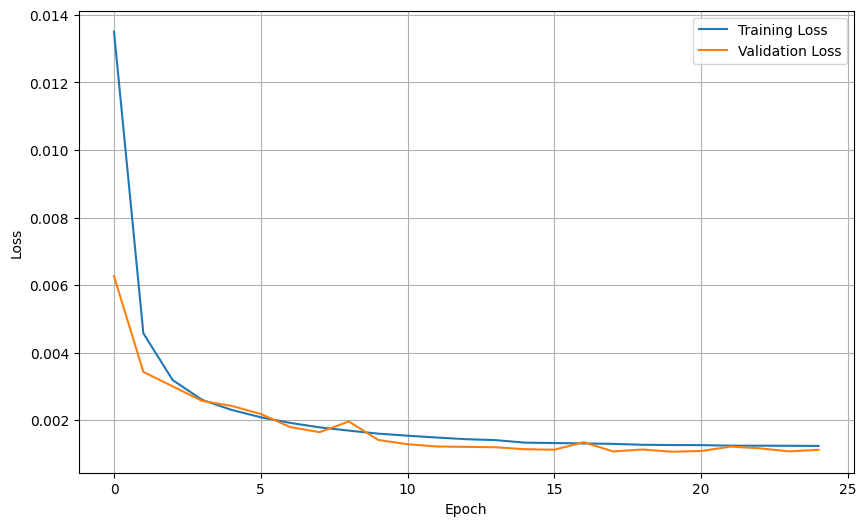

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_point_history.history["loss"], label="Training Loss")
plt.plot(lstm_point_history.history["val_loss"], label="Validation Loss")
# plt.title("Model Loss During Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("lstm_point_model_loss_during_training.png", dpi=300, bbox_inches="tight")
plt.show()

-------- LSTM Point Train metrics --------
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 7.1047
MSE: 112.3357
RMSE: 10.5989
MAPE: 9.2569
R2: 0.9711

-------- LSTM Point Validation metrics --------
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 6.0836
MSE: 73.7481
RMSE: 8.5877
MAPE: 13.7551
R2: 0.9545

-------- LSTM Point Test metrics --------
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 6.2786
MSE: 81.1483
RMSE: 9.0082
MAPE: 13.5610
R2: 0.9324


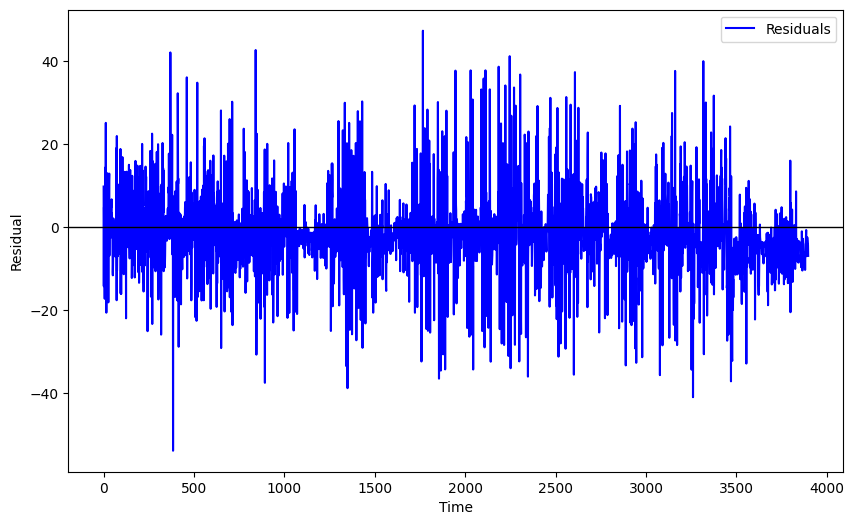

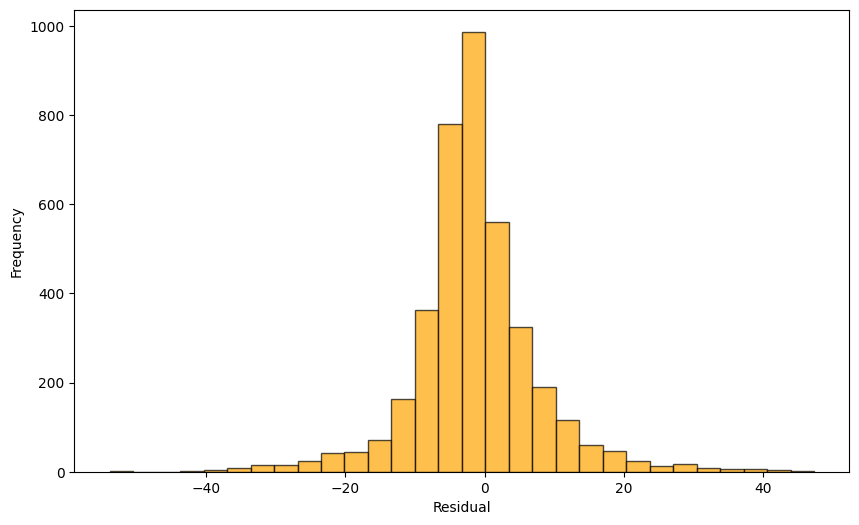

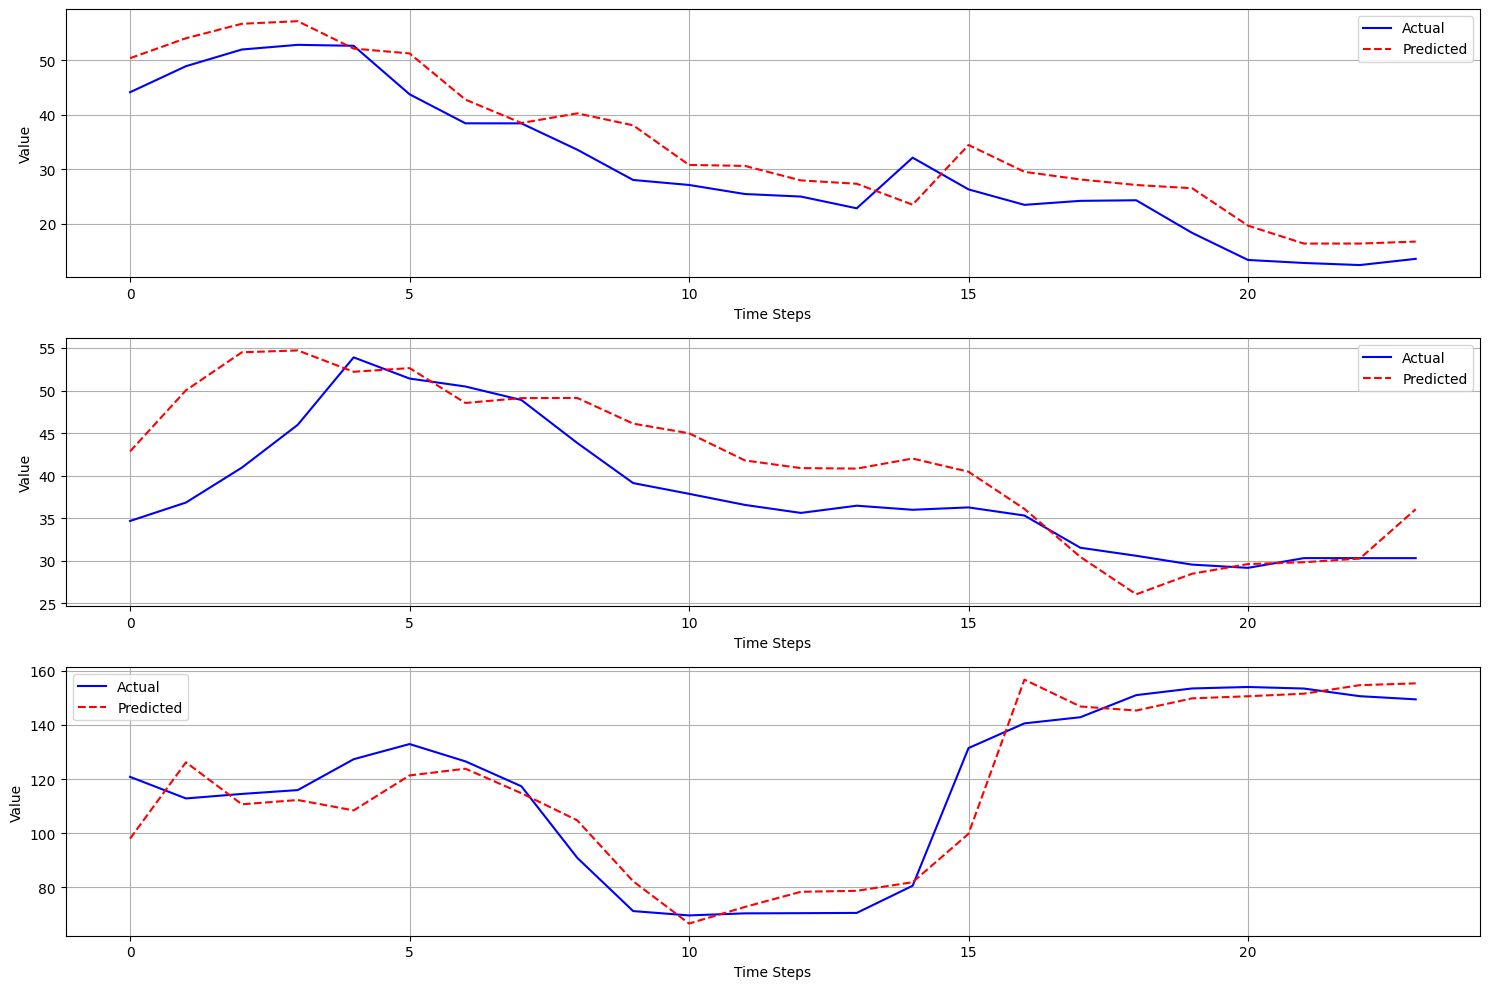

In [5]:
lstm_point_model = tf.keras.models.load_model("lstm_point.keras")

print("-------- LSTM Point Train metrics --------")
lstm_point_train_predictions = lstm_point_train_prepped.y_scaler.inverse_transform(
    lstm_point_model.predict([lstm_point_train_prepped.x_tensor_hist, lstm_point_train_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_point_train_actuals = lstm_point_train_prepped.y_scaler.inverse_transform(lstm_point_train_prepped.y_tensor.numpy().reshape(-1, 1))
lstm_point_train_metrics = calculate_metrics(lstm_point_train_predictions, lstm_point_train_actuals)

print("\n-------- LSTM Point Validation metrics --------")
lstm_point_validation_predictions = lstm_point_train_prepped.y_scaler.inverse_transform(
    lstm_point_model.predict([lstm_point_validation_prepped.x_tensor_hist, lstm_point_validation_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_point_validation_actuals = lstm_point_train_prepped.y_scaler.inverse_transform(
    lstm_point_validation_prepped.y_tensor.numpy().reshape(-1, 1)
)
lstm_point_test_metrics = calculate_metrics(lstm_point_validation_predictions, lstm_point_validation_actuals)

print("\n-------- LSTM Point Test metrics --------")
lstm_point_test_predictions = lstm_point_train_prepped.y_scaler.inverse_transform(
    lstm_point_model.predict([lstm_point_test_prepped.x_tensor_hist, lstm_point_test_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_point_test_actuals = lstm_point_train_prepped.y_scaler.inverse_transform(lstm_point_test_prepped.y_tensor.numpy().reshape(-1, 1))
lstm_point_test_metrics = calculate_metrics(lstm_point_test_predictions, lstm_point_test_actuals)
plot_residuals(lstm_point_test_predictions, lstm_point_test_actuals, title="Residual plot", save_name="lstm_point_test_residuals")
plot_predictions_vs_actuals_v2(lstm_point_test_predictions, lstm_point_test_actuals, save_name="lstm_point_test_pred_vs_acts.png")

# LSTM - SEQUENCE


In [ ]:
LSTM_SEQ_INPUT_SEQ_LEN = 48
LSTM_SEQ_OUTPUT_SEQ_LEN = 24

lstm_seq_train_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_train,
    input_seq_len=LSTM_SEQ_INPUT_SEQ_LEN,
    output_seq_len=LSTM_SEQ_OUTPUT_SEQ_LEN,
    x_scaler_hist=None,
    x_scaler_future=None,
    y_scaler=None,
)

lstm_seq_validation_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_validation,
    input_seq_len=LSTM_SEQ_INPUT_SEQ_LEN,
    output_seq_len=LSTM_SEQ_OUTPUT_SEQ_LEN,
    x_scaler_hist=lstm_seq_train_prepped.x_scaler_hist,
    x_scaler_future=lstm_seq_train_prepped.x_scaler_future,
    y_scaler=lstm_seq_train_prepped.y_scaler,
)

lstm_seq_test_prepped = lstm_transform_and_prep_data_with_forecasts(
    df=df_test,
    input_seq_len=LSTM_SEQ_INPUT_SEQ_LEN,
    output_seq_len=LSTM_SEQ_OUTPUT_SEQ_LEN,
    x_scaler_hist=lstm_seq_train_prepped.x_scaler_hist,
    x_scaler_future=lstm_seq_train_prepped.x_scaler_future,
    y_scaler=lstm_seq_train_prepped.y_scaler,
)

print(f"X hist tensor shape: {lstm_seq_train_prepped.x_tensor_hist.shape}")
print(f"X future tensor shape: {lstm_seq_train_prepped.x_tensor_future.shape}")
print(f"Y tensor shape: {lstm_seq_train_prepped.y_tensor.shape}")

n_hist_features = lstm_seq_train_prepped.x_tensor_hist.shape[2]
n_future_features = lstm_seq_train_prepped.x_tensor_future.shape[2]

inputs_hist = tf.keras.layers.Input(shape=(LSTM_SEQ_INPUT_SEQ_LEN, n_hist_features))
inputs_future = tf.keras.layers.Input(shape=(LSTM_SEQ_OUTPUT_SEQ_LEN, n_future_features))

encoder = tf.keras.layers.LSTM(32, return_state=True)(inputs_hist)
encoder_outputs, encoder_state_h, encoder_state_c = encoder

decoder = tf.keras.layers.LSTM(32, return_sequences=True)(inputs_future, initial_state=[encoder_state_h, encoder_state_c])

outputs = tf.keras.layers.Dense(1)(decoder)

lstm_seq_model = tf.keras.Model(inputs=[inputs_hist, inputs_future], outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
lstm_seq_model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1,
)

LSTM_SEQ_BATCH_SIZE = 64

lstm_seq_history = lstm_seq_model.fit(
    [lstm_seq_train_prepped.x_tensor_hist, lstm_seq_train_prepped.x_tensor_future],
    lstm_seq_train_prepped.y_tensor,
    validation_data=(
        [lstm_seq_validation_prepped.x_tensor_hist, lstm_seq_validation_prepped.x_tensor_future],
        lstm_seq_validation_prepped.y_tensor,
    ),
    batch_size=LSTM_SEQ_BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler],
)

lstm_seq_model.save("lstm_seq.keras")

X hist tensor shape: (18341, 48, 22)
X future tensor shape: (18341, 24, 21)
Y tensor shape: (18341, 24, 1)
Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0483 - mae: 0.1632 - val_loss: 0.0206 - val_mae: 0.1132 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0176 - mae: 0.1032 - val_loss: 0.0139 - val_mae: 0.0927 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0128 - mae: 0.0873 - val_loss: 0.0097 - val_mae: 0.0778 - learning_rate: 1.0000e-04
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - mae: 0.0725 - val_loss: 0.0105 - val_mae: 0.0845 - learning_rate: 1.0000e-04
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0075 - mae: 0.0644 - val_loss: 0.0099 - val_mae: 0.0811 - learning_rate: 1.0000e-04
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0617 - val_loss: 0.0094 - val_mae: 0.0782 - learning_rate: 1.0000e-04
Epoch 7/100

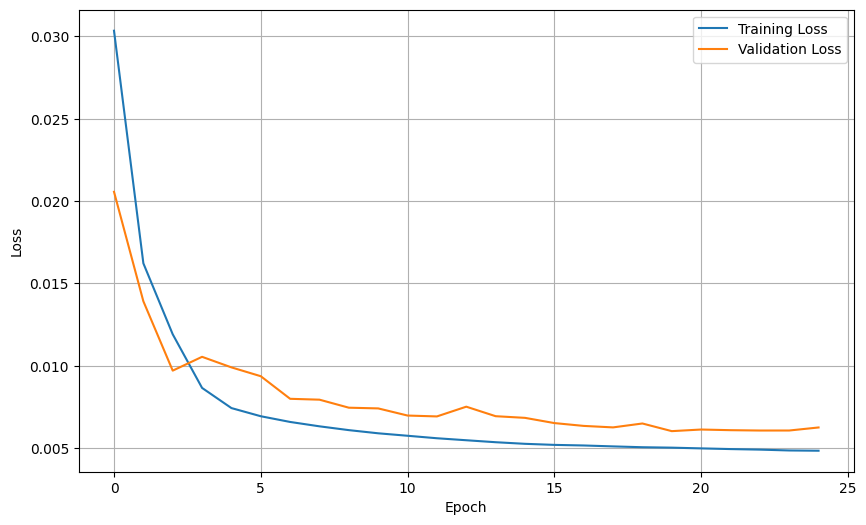

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_seq_history.history["loss"], label="Training Loss")
plt.plot(lstm_seq_history.history["val_loss"], label="Validation Loss")
# plt.title("Model Loss During Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("lstm_seq_model_loss_during_training.png", dpi=300, bbox_inches="tight")
plt.show()

-------- LSTM Sequence Train metrics --------
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 14.0810
MSE: 395.8623
RMSE: 19.8963
MAPE: 20.0476
R2: 0.8981

-------- LSTM Sequence Validation metrics --------
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 16.6106
MSE: 462.5824
RMSE: 21.5077
MAPE: 46.7331
R2: 0.7098

-------- LSTM Sequence Test metrics --------
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 16.3213
MSE: 492.9387
RMSE: 22.2022
MAPE: 33.1465
R2: 0.5894


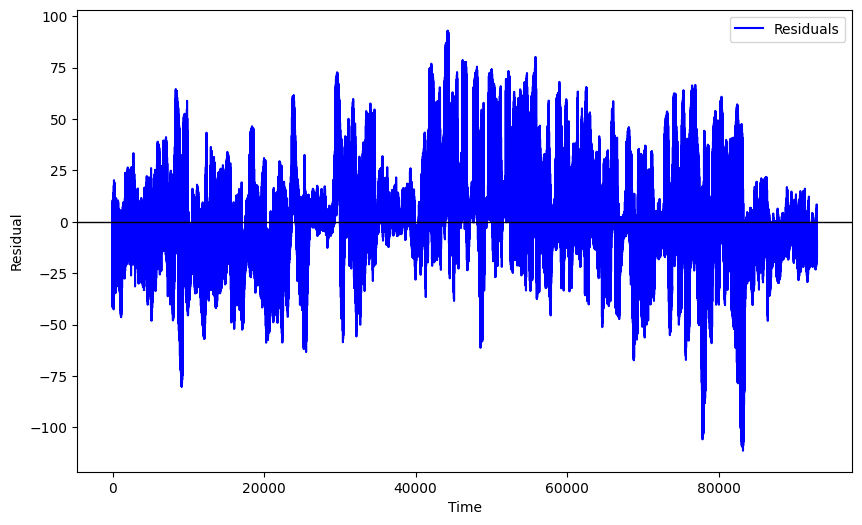

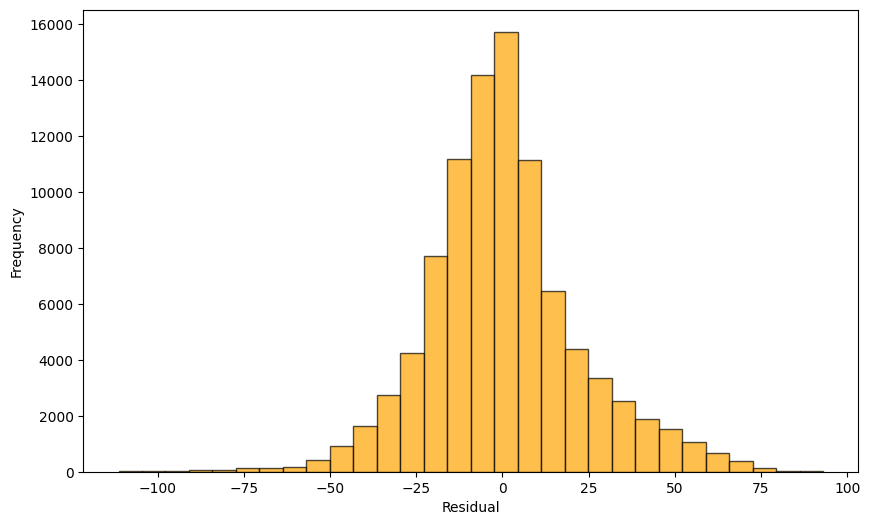

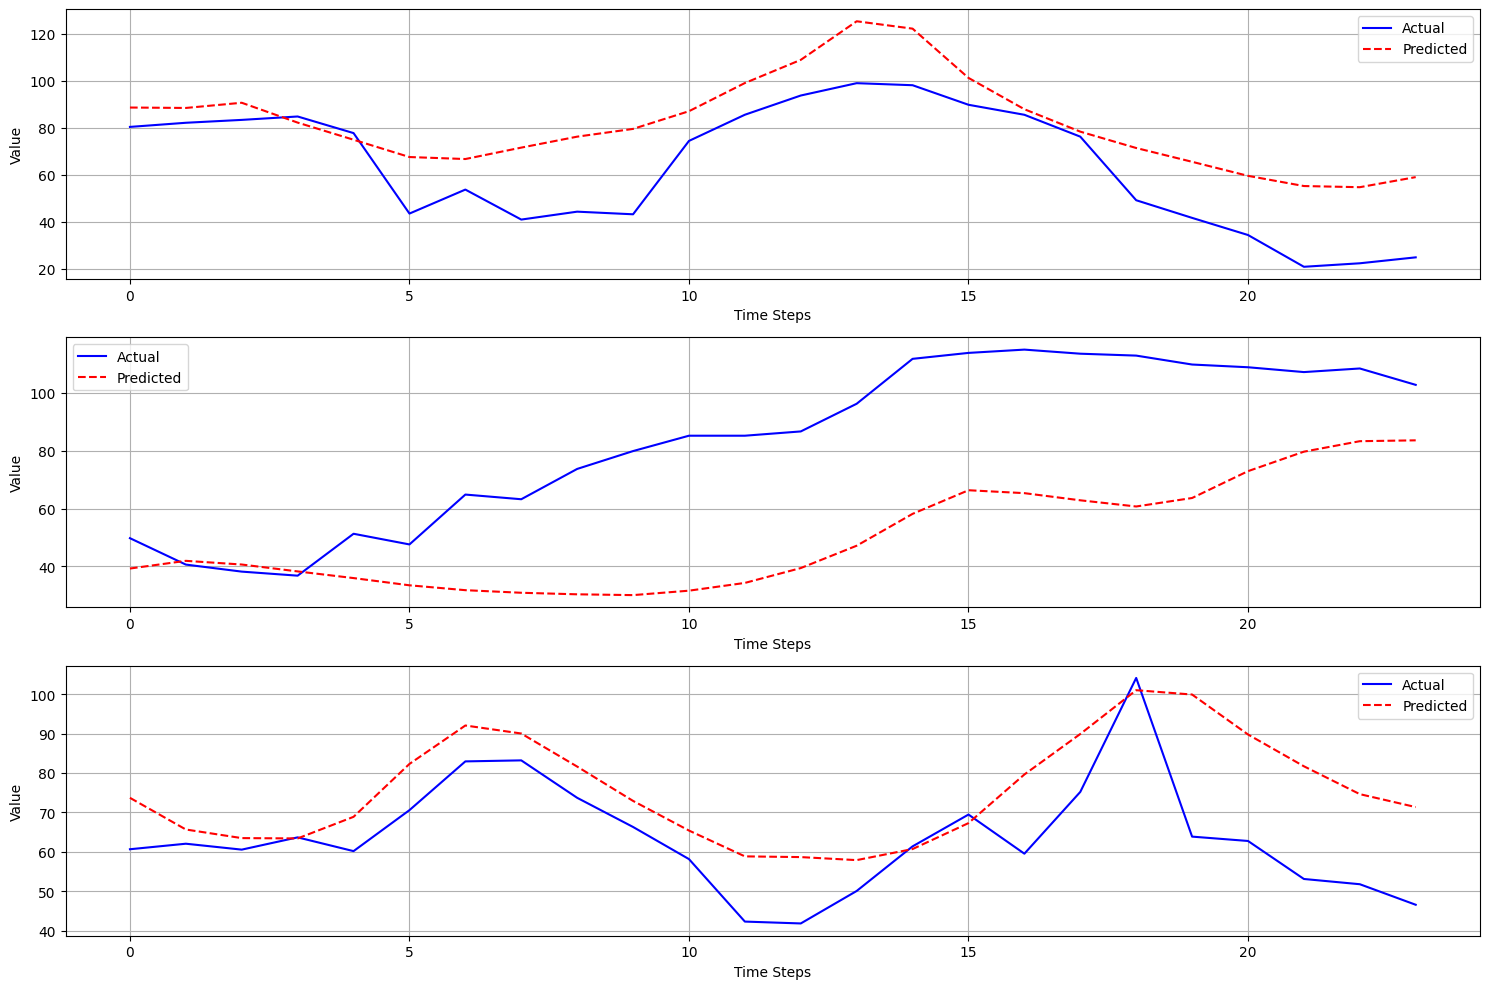

In [8]:
lstm_seq_model = tf.keras.models.load_model("lstm_seq.keras")

print("-------- LSTM Sequence Train metrics --------")
lstm_seq_train_predictions = lstm_seq_train_prepped.y_scaler.inverse_transform(
    lstm_seq_model.predict([lstm_seq_train_prepped.x_tensor_hist, lstm_seq_train_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_seq_train_actuals = lstm_seq_train_prepped.y_scaler.inverse_transform(lstm_seq_train_prepped.y_tensor.numpy().reshape(-1, 1))
lstm_seq_train_metrics = calculate_metrics(lstm_seq_train_predictions, lstm_seq_train_actuals)

print("\n-------- LSTM Sequence Validation metrics --------")
lstm_seq_validation_predictions = lstm_seq_train_prepped.y_scaler.inverse_transform(
    lstm_seq_model.predict([lstm_seq_validation_prepped.x_tensor_hist, lstm_seq_validation_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_seq_validation_actuals = lstm_seq_train_prepped.y_scaler.inverse_transform(lstm_seq_validation_prepped.y_tensor.numpy().reshape(-1, 1))
lstm_seq_validation_metrics = calculate_metrics(lstm_seq_validation_predictions, lstm_seq_validation_actuals)

print("\n-------- LSTM Sequence Test metrics --------")
lstm_seq_test_predictions = lstm_seq_train_prepped.y_scaler.inverse_transform(
    lstm_seq_model.predict([lstm_seq_test_prepped.x_tensor_hist, lstm_seq_test_prepped.x_tensor_future]).reshape(-1, 1)
)
lstm_seq_test_actuals = lstm_seq_train_prepped.y_scaler.inverse_transform(lstm_seq_test_prepped.y_tensor.numpy().reshape(-1, 1))
lstm_seq_test_metrics = calculate_metrics(lstm_seq_test_predictions, lstm_seq_test_actuals)
plot_residuals(lstm_seq_test_predictions, lstm_seq_test_actuals, title="Residual plot", save_name="lstm_seq_test_residuals")
plot_predictions_vs_actuals_v2(lstm_seq_test_predictions, lstm_seq_test_actuals, save_name="lstm_seq_test_pred_vs_acts.png")

# FEATURE IMPORTANCE ANALYSIS


In [9]:
baseline_actuals = lstm_seq_train_prepped.y_scaler.inverse_transform(lstm_seq_validation_prepped.y_tensor.numpy().reshape(-1, 1))
baseline_rmse = lstm_seq_validation_metrics["RMSE"]

print(f"Baseline Validation RMSE: {baseline_rmse:.4f}")

lstm_seq_importance_scores = {}

print("\nCalculating importance for historical features...")
for i, feature_name in enumerate(FEATURES_HIST):
    rmse_drops = []

    for repeat in range(10):
        np.random.seed(repeat)

        x_permuted = lstm_seq_validation_prepped.x_tensor_hist.numpy().copy()
        permuted_indices = np.random.permutation(x_permuted.shape[0])
        x_permuted[:, :, i] = x_permuted[permuted_indices, :, i]
        x_hist_permuted = tf.convert_to_tensor(x_permuted, dtype=tf.float32)

        permuted_predictions = lstm_seq_train_prepped.y_scaler.inverse_transform(
            lstm_seq_model.predict([x_hist_permuted, lstm_seq_validation_prepped.x_tensor_future]).reshape(-1, 1)
        )

        permuted_rmse = calculate_metrics(permuted_predictions, baseline_actuals, verbose=False)["RMSE"]
        rmse_drop = permuted_rmse - baseline_rmse
        rmse_drops.append(rmse_drop)

    lstm_seq_importance_scores[f"hist_{feature_name}"] = np.mean(rmse_drops)
    print(f"  {feature_name}: {np.mean(rmse_drops):.4f} ± {np.std(rmse_drops):.4f}")

print("\nCalculating importance for future features...")
for i, feature_name in enumerate(FEATURES_FUTURE):
    rmse_drops = []

    for repeat in range(10):
        np.random.seed(repeat)

        x_permuted = lstm_seq_validation_prepped.x_tensor_future.numpy().copy()
        permuted_indices = np.random.permutation(x_permuted.shape[0])
        x_permuted[:, :, i] = x_permuted[permuted_indices, :, i]
        x_future_permuted = tf.convert_to_tensor(x_permuted, dtype=tf.float32)

        permuted_predictions = lstm_seq_train_prepped.y_scaler.inverse_transform(
            lstm_seq_model.predict([lstm_seq_validation_prepped.x_tensor_hist, x_future_permuted]).reshape(-1, 1)
        )

        permuted_rmse = calculate_metrics(permuted_predictions, baseline_actuals, verbose=False)["RMSE"]
        rmse_drop = permuted_rmse - baseline_rmse
        rmse_drops.append(rmse_drop)

    lstm_seq_importance_scores[f"future_{feature_name}"] = np.mean(rmse_drops)
    print(f"  {feature_name}: {np.mean(rmse_drops):.4f} ± {np.std(rmse_drops):.4f}")

Baseline Validation RMSE: 21.5077

Calculating importance for historical features...
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  t_hours_since_start: 0.4229 ± 0.0170
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  t_days_since_start: -0.2100 ± 0.0122
122/122 ━━━━━━━━━

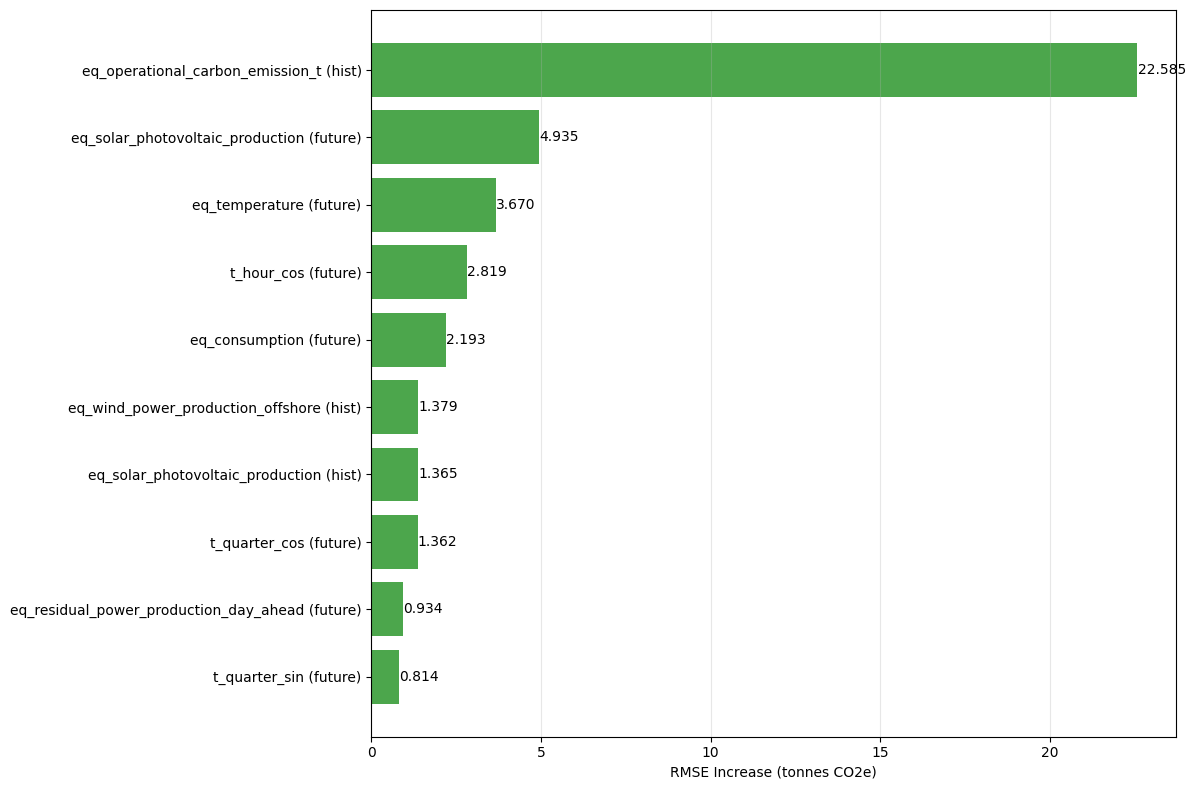

In [10]:
sorted_features = sorted(lstm_seq_importance_scores.items(), key=lambda x: abs(x[1]), reverse=True)
top_k = 10
top_features = sorted_features[:top_k]

features, scores = zip(*top_features)

clean_features = []
for f in features:
    if f.startswith("hist_"):
        clean_features.append(f[5:] + " (hist)")
    elif f.startswith("future_"):
        clean_features.append(f[7:] + " (future)")
    else:
        clean_features.append(f)

clean_features = clean_features[::-1]
scores = scores[::-1]

plt.figure(figsize=(12, 8))
colors = ["red" if score < 0 else "green" for score in scores]
bars = plt.barh(range(len(clean_features)), scores, color=colors, alpha=0.7)

plt.yticks(range(len(clean_features)), clean_features)
plt.xlabel("RMSE Increase (tonnes CO2e)")
# plt.title("Feature Importance (Permutation Analysis)")
plt.grid(axis="x", alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(score + (0.01 if score >= 0 else -0.01), i, f"{score:.3f}", ha="left" if score >= 0 else "right", va="center")

plt.tight_layout()
plt.savefig("lstm_seq_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
df_importance = (
    pl.DataFrame({"Feature": list(lstm_seq_importance_scores.keys()), "Importance": list(lstm_seq_importance_scores.values())})
    .with_columns(pl.col("Importance").abs().alias("abs_importance"))
    .sort("abs_importance", descending=True)
    .drop("abs_importance")
)

df_importance.write_csv("lstm_seq_feature_importance.csv")

print("\nTop Most Important Features:")
print(df_importance)


Top Most Important Features:
shape: (43, 2)
┌─────────────────────────────────┬────────────┐
│ Feature                         ┆ Importance │
│ ---                             ┆ ---        │
│ str                             ┆ f32        │
╞═════════════════════════════════╪════════════╡
│ hist_eq_operational_carbon_emi… ┆ 22.584778  │
│ future_eq_solar_photovoltaic_p… ┆ 4.934506   │
│ future_eq_temperature           ┆ 3.670223   │
│ future_t_hour_cos               ┆ 2.819004   │
│ future_eq_consumption           ┆ 2.193365   │
│ …                               ┆ …          │
│ hist_eq_price_spot_day_ahead_e… ┆ 0.016527   │
│ hist_t_quarter_cos              ┆ 0.012396   │
│ future_eq_wind_power_productio… ┆ -0.005174  │
│ hist_t_year                     ┆ 0.0        │
│ future_t_year                   ┆ 0.0        │
└─────────────────────────────────┴────────────┘


# DIEBOLD-MARIANO


In [19]:
def diebold_mariano_test(actual: np.ndarray, pred_1: np.ndarray, pred_2: np.ndarray, h: int = 1) -> tuple:
    # Calculate squared errors
    e1 = (actual - pred_1) ** 2
    e2 = (actual - pred_2) ** 2

    # Loss differential
    d = e1 - e2
    d_mean = np.mean(d)

    # Calculate variance (with autocorrelation adjustment for h > 1)
    n = len(d)
    if h == 1:
        d_var = np.var(d, ddof=1) / n
    else:
        # Simple autocorrelation adjustment
        d_var = np.var(d, ddof=1) / n
        for lag in range(1, min(h, n // 4)):
            if n > lag:
                autocovar = np.mean((d[:-lag] - d_mean) * (d[lag:] - d_mean))
                d_var += 2 * autocovar / n

    # DM statistic
    dm_stat = d_mean / np.sqrt(abs(d_var))

    # p-value (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    # Interpretation
    if p_value < 0.05:
        if d_mean < 0:
            result = "Model 1 significantly better"
        else:
            result = "Model 2 significantly better"
    else:
        result = "No significant difference"

    print(f"    DM statistic: {dm_stat:.4f}")
    print(f"    p-value: {p_value:.10f}")
    print(f"    Result: {result}")

    return dm_stat, p_value, result

In [20]:
# LSTM PREDICTIONS
lstm_point_test_actuals_flat = lstm_point_test_actuals.flatten()
lstm_seq_test_actuals_flat = lstm_seq_test_actuals.flatten()

lstm_point_test_predictions_flat = lstm_point_test_predictions.flatten()
lstm_seq_test_predictions_flat = lstm_seq_test_predictions.flatten()

# NAIVE PREDICTIONS
naive_point_adjustment = naive_point_test_predictions.shape[0] - lstm_point_test_predictions.shape[0]
naive_seq_adjustment = naive_seq_test_predictions.shape[0] - (lstm_seq_test_predictions.shape[0] // LSTM_SEQ_OUTPUT_SEQ_LEN)

naive_point_test_predictions_flat = naive_point_test_predictions[naive_point_adjustment:].flatten()
naive_seq_test_predictions_flat = naive_seq_test_predictions[naive_seq_adjustment:].flatten()

# ARIMA PREDICTONS
arima_point_model = ARIMAResults.load("arimas/p_5_d_0_q_5_t_n.pkl")
arima_seq_model = ARIMAResults.load("arimas/p_5_d_0_q_5_t_n.pkl")

arima_point_test_predictions, arima_point_test_actuals = arima_predict(arima_point_model, arima_test_prepped, horizon=1)
arima_seq_test_predictions, arima_seq_test_actuals = arima_predict(arima_seq_model, arima_test_prepped, horizon=24)

arima_point_adjustment = arima_point_test_predictions.shape[0] - lstm_point_test_predictions.shape[0]
arima_seq_adjustment = arima_seq_test_predictions.shape[0] - (lstm_seq_test_predictions.shape[0] // LSTM_SEQ_OUTPUT_SEQ_LEN)

arima_point_test_predictions_flat = arima_point_test_predictions[arima_point_adjustment:].flatten()
arima_point_test_actuals_flat = arima_point_test_actuals[arima_point_adjustment:].flatten()

arima_seq_test_predictions_flat = arima_seq_test_predictions[arima_seq_adjustment:].flatten()
arima_seq_test_actuals_flat = arima_seq_test_actuals[arima_seq_adjustment:].flatten()

print("ARIMA (1-hour) vs Naive (1-hour):")
_ = diebold_mariano_test(
    actual=arima_point_test_actuals_flat,
    pred_1=arima_point_test_predictions_flat,
    pred_2=naive_point_test_predictions_flat,
    h=1,
)

print("\nLSTM (1-hour) vs Naive (1-hour):")
_ = diebold_mariano_test(
    actual=lstm_point_test_actuals_flat,
    pred_1=lstm_point_test_predictions_flat,
    pred_2=naive_point_test_predictions_flat,
    h=1,
)

print("\nLSTM (1-hour) vs ARIMA (1-hour):")
_ = diebold_mariano_test(
    actual=lstm_point_test_actuals_flat,
    pred_1=lstm_point_test_predictions_flat,
    pred_2=arima_point_test_predictions_flat,
    h=1,
)

print("\nARIMA (24-hour) vs Naive (24-hour):")
_ = diebold_mariano_test(
    actual=arima_seq_test_actuals_flat,
    pred_1=arima_seq_test_predictions_flat,
    pred_2=naive_seq_test_predictions_flat,
    h=24,
)

print("\nLSTM (24-hour) vs Naive (24-hour):")
_ = diebold_mariano_test(
    actual=lstm_seq_test_actuals_flat,
    pred_1=lstm_seq_test_predictions_flat,
    pred_2=naive_seq_test_predictions_flat,
    h=24,
)

print("\nLSTM (24-hour) vs ARIMA (24-hour):")
_ = diebold_mariano_test(
    actual=lstm_seq_test_actuals_flat,
    pred_1=lstm_seq_test_predictions_flat,
    pred_2=arima_seq_test_predictions_flat,
    h=24,
)

ARIMA (1-hour) vs Naive (1-hour):
    DM statistic: -12.1225
    p-value: 0.0000000000
    Result: Model 1 significantly better

LSTM (1-hour) vs Naive (1-hour):
    DM statistic: -10.0489
    p-value: 0.0000000000
    Result: Model 1 significantly better

LSTM (1-hour) vs ARIMA (1-hour):
    DM statistic: -3.6737
    p-value: 0.0002390276
    Result: Model 1 significantly better

ARIMA (24-hour) vs Naive (24-hour):
    DM statistic: -16.1451
    p-value: 0.0000000000
    Result: Model 1 significantly better

LSTM (24-hour) vs Naive (24-hour):
    DM statistic: -19.1230
    p-value: 0.0000000000
    Result: Model 1 significantly better

LSTM (24-hour) vs ARIMA (24-hour):
    DM statistic: -9.6456
    p-value: 0.0000000000
    Result: Model 1 significantly better
